TODO
 * Find a way of properly cutting off LFIs for cov2covsmooth() and build_covmatrix()
 * SMICA needs to run correctly again for all dsets and masks (Signal-fit is very poor at the moment)
 * run for NPIPE sim
 * How well does the fit do? Check error bars on spectral mismatch
 * Start draft
 * run foreground cleaning on PICO data
 
 * Fix error on delensing on MV maps
 * preprocessing: validate and check dependence on mask / dataset
 * derive theoretical N0

In [1]:
%%capture

import os, sys
import json
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from healpy.sphtfunc import smoothing
import smica
import copy
from astropy.io import fits
from scipy import interpolate

from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.io import IO
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen as fn_gen
from component_separation.cs_util import Filename_gen_SMICA as fns_gen

import component_separation.smica_interface as smint
import component_separation.map as mp
import component_separation.covariance as cv

csu = Config()
io = IO(csu)
fn = fn_gen(csu)
fns = fns_gen(csu)

TEB = 1

# SMICA input and ouptput
Config.json specific
## Header

In [2]:
lmaxbins = int(csu.bins[-1][1])
colors = csu.CB_color_cycle
Tscale = "K_CMB"
bins = csu.bins

In [3]:
Cl_tot = io.load_data(fn.get_spectrum("T", "non-separated"))
covl_tot = cv.build_covmatrices(Cl_tot, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

Cl_N = io.load_data(fn.get_spectrum("N", "non-separated"))
covl_N = cv.build_covmatrices(Cl_N, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

Cl_S = io.load_data(fns.get_spectrum("S", "non-separated"))
covl_S = cv.build_covmatrices(Cl_S, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
for k, v in smica_params.items():
    smica_params[k] = io.load_data(fns.get_misc(k))

Cl_min = io.load_data(fns.get_spectrum("T", "combined"))
# covl_min = cv.build_covmatrices(Cl_min, Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

# tf = io.load_data(io.fh.out_misc_path+"tf_{}".format(csu.binname) + "_" + filename)
# hist = io.load_data(io.fh.out_specsmica_path+"hist_{}".format(csu.cf['pa']['binname']) + "_" + io.fh.total_filename)

loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/ClT_non-separated_2048_4000_6000_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/ClN_non-separated_2048_4000_6000_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/Sest/ClS_NPIPEsim.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_cov_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_cov4D_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_CMB_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_gal_mm_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_w_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/ClT_combined_SMICA_highell_bins_2048_4000_6000_JC.npy


In [4]:
covl_tot_bnd = hpf.bin_it(covl_tot[TEB], bins=bins)
covl_N_bnd = hpf.bin_it(covl_N[TEB], bins=bins)
covl_N_bnd = np.diagonal(covl_N_bnd, axis1=0, axis2=1).T
covl_S_bnd =  hpf.bin_it(covl_S[TEB], bins=bins)

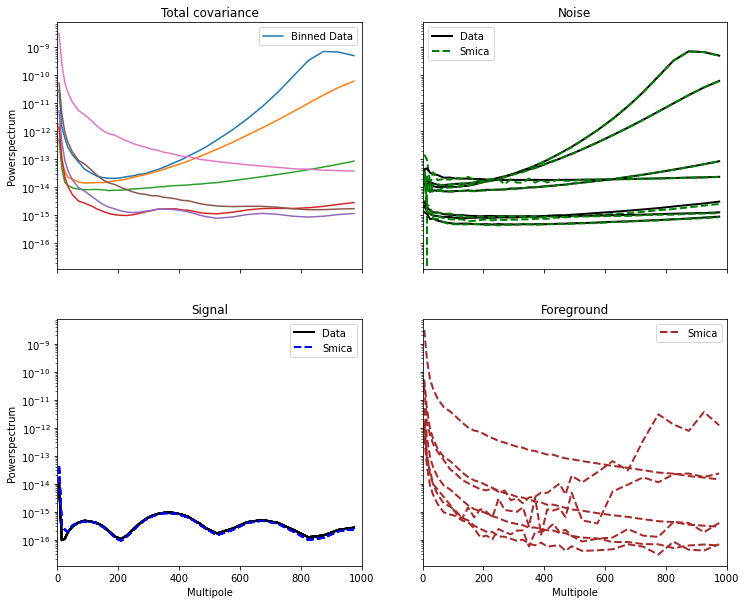

In [5]:
#%matplotlib widget
fig, axs = plt.subplots(2,2, figsize=(12,10), sharex=True,  sharey=True)
def logi(a, b):
    return a==b# and a>=3 and b>=3
ax=axs[0,0]
ax.set_title('Total covariance')
ax.set_yscale('log')
ax.set_ylabel('Powerspectrum')
ax.set_xlim((0,1000))
# ax.set_ylim((1e-7,1e1))
lab1 = 'Binned Data'
lab3 = 'Data'
lab2 = 'Smica'
for n in range(covl_tot_bnd.shape[1]):
    for m in range(covl_tot_bnd.shape[1]):
        if logi(n, m):# and n<3 and m<3:
#             ax.plot(covl_tot[1,n,m,:], color = 'black', ls='--', label=lab3, alpha=0.1)
            if n==m:
                ax.plot(np.mean(bins, axis=1), covl_tot_bnd[n,m,:], label=lab1)
            else:
                ax.plot(np.mean(bins, axis=1), covl_tot_bnd[n,m,:], label=lab1)
#             ax.plot(covl_totEE[n,m,:], label=lab1, color = 'black')
            lab1 = None
            lab2 = None
            lab3 = None
ax.legend()

ax=axs[0,1]
ax.set_title('Noise')
ax.set_yscale('log')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(covl_N.shape[1]):
    for m in range(covl_tot_bnd.shape[1]):
         if logi(n, m):
            if n==m:
                ax.plot(np.mean(bins, axis=1), covl_N_bnd[n,:], color= 'black', lw=2, label=lab1)
                ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,2], color= 'green', lw=2, label=lab2, ls='--')
                lab1 = None
                lab2 = None
                ax.legend()         
            else:
                ax.text(lmaxbins-100, 1e0, 'Noise diagonal')

ax=axs[1,0]
ax.set_title('Signal')
ax.set_xlabel('Multipole')
ax.set_yscale('log')
ax.set_ylabel('Powerspectrum')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(covl_S_bnd.shape[0]):
    for m in range(covl_S_bnd.shape[1]):
        if logi(n, m):
            ax.plot(np.mean(bins, axis=1), covl_S_bnd[n,m,:], color= 'black', lw=2, label=lab1)
            ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,0], color= 'blue', lw=2, label=lab2, ls='--')
            lab1 = None
            lab2 = None
ax.legend()

ax=axs[1,1]
ax.set_title('Foreground')
ax.set_xlabel('Multipole')
ax.set_yscale('log')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(smica_params['cov4D'].shape[1]):
    for m in range(smica_params['cov4D'].shape[2]):
        if logi(n, m):
            ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,1], color= 'brown', lw=2, label=lab2, ls='--')
            lab1 = None
            lab2 = None
ax.legend()

Text(0.5, 1.0, 'Noise amplitude change in SMICA fit')

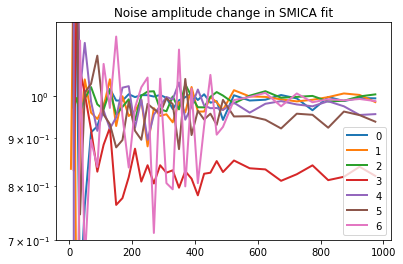

In [6]:
for n in range(covl_N.shape[1]):
    for m in range(covl_tot_bnd.shape[1]):
         if logi(n, m):
            if n==m:
                plt.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,2]/covl_N_bnd[n,:], lw=2, label=n, alpha=1.0)
                lab1 = None
                lab2 = None
                plt.legend()
plt.yscale('log')
plt.ylim((0.7,1.2))
plt.title('Noise amplitude change in SMICA fit')

In [24]:
W_data = io.load_data("/global/cscratch1/sd/sebibel/compsep/DX12/smicamask/w_JC.npy")
W_smica = io.load_data("/global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_w_SMICA_highell_bins_JC.npy")

W_propag = np.loadtxt("/global/homes/s/sebibel/ext/smica_propagation/weights_EB_smica_R3.00.txt").reshape(2,7,4001)
beam5 = hp.gauss_beam(0.00145444, csu.lmax, pol = True)[:,1]
bcorr = np.array([
    hp.gauss_beam(val, csu.lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ])

loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/w_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/smica_w_SMICA_highell_bins_JC.npy


/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:767: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:768: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:768: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:767: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:768: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:768: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/g

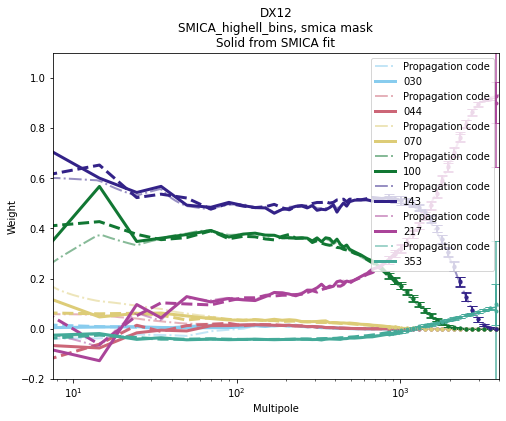

In [19]:
fig = plt.figure(figsize=(8,6))
plt.ylim((-0.2,1.1))
plt.title('{}\n{}, {} mask\nSolid from SMICA fit'.format(csu.freqdset, csu.binname, csu.mskset))
plt.xlabel('Multipole')
plt.ylabel('Weight')
#     plt.xscale('log')
lab1 = 'Propagation code'
for freq in range(0, 7):#W_smica.shape[1]):
    freqc = '-'.join([csu.PLANCKMAPFREQ[freq],csu.PLANCKMAPFREQ[freq]])

    #only for DX12 data
    plt.plot(W_propag[TEB-1,freq,:]*bcorr[freq]/beam5, color=colors[freq], label=lab1, lw=2, alpha=0.5, ls='-.')
     # lab1=None

    #This is the fitting result
    plt.plot(np.mean(bins, axis=1), W_smica[0,freq,:], color=colors[freq], label=csu.PLANCKMAPFREQ[freq], lw=3, ls='-')
    plt.plot(np.mean(bins, axis=1), W_smica[1,freq,:], color=colors[freq], lw=3, ls='--')
#         print(np.sum(((1+np.sum(W_s[0,0:3,:],axis=0))*W_s[0,3:7,:]),axis=0))pmask

    #This is the mv result
    mean, std, _ = hpf.std_dev_binned(np.nan_to_num(W_data[1,freq,:]), binwidth=100, lmax=csu.lmax+1, log=True)
    plt.errorbar(((_[1:]+_[:-1])/2)[80:], mean[80:], yerr=std[80:], alpha=0.9, fmt='.', capsize=5, lw=2, color=colors[freq])

    mean, std, _ = hpf.std_dev_binned(np.nan_to_num(W_data[2,freq,:]), binwidth=100, lmax=csu.lmax+1, log=True)
    plt.errorbar(((_[1:]+_[:-1])/2)[80:], mean[80:], yerr=std[80:], alpha=0.9, fmt='.', capsize=5, color=colors[freq])

plt.legend(loc='upper right')
plt.xlim((7.5,csu.lmax))
# plt.ylim((-0.05,0.2))
plt.xscale('log')

In [20]:
from component_separation.config_planck import Lens_Mask as LM
from component_separation.config_planck import Smica_Mask as SM

Tmask_LMfn = [os.path.join(LM.get_dir(), fn) 
    for fn in LM.get_fn("T")]
Pmask_LMfn = [os.path.join(LM.get_dir(), fn) 
    for fn in LM.get_fn("P")]

Tmask_SMfn = [os.path.join(SM.get_dir(), fn) 
    for fn in LM.get_fn("T")]
Pmask_SMfn = [os.path.join(SM.get_dir(), fn) 
    for fn in SM.get_fn("P")]

Tmask_LM = io.load_mask(Tmask_LMfn, stack=True)
Pmask_LM = io.load_mask(Pmask_LMfn, stack=True)

Tmask_SM = io.load_mask(Tmask_SMfn, stack=True)
Pmask_SM = io.load_mask(Pmask_SMfn, stack=True)

csuDXS = copy.copy(csu)
csuDXS.freqdset = 'DX12'
csuDXS.mskset = 'smica'
ioDXS= IO(csuDXS)
fnDXS= fn_gen(csuDXS)
fnsDXS = fns_gen(csuDXS)

csuNPL = copy.copy(csu)
csuNPL.freqdset = 'NPIPE'
csuNPL.mskset = 'lens'
ioNPL= IO(csuNPL)
fnNPL= fn_gen(csuNPL)
fnsNPL = fns_gen(csuNPL)

mapC_DXS = io.load_data(fnsDXS.get_map('T', 'combined'))
ClC_DXS = io.load_data(fnsDXS.get_spectrum('T', 'combined'))

# mapC_NPL = io.load_data(fnNPL.get_map('T', 'combined'))
# mapC_NPL = io.load_data(fnNPL.get_spectrum('T', 'combined'))

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


no existing data at /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/MapT_combined_SMICA_highell_bins_2048_4000_6000_JC.npy
no existing data at /global/cscratch1/sd/sebibel/compsep/DX12/smicamask/ClT_combined_SMICA_highell_bins_2048_4000_6000_JC.npy


In [21]:
plt.plot(ClC_DXS[0][1])
plt.yscale('log')

TypeError: 'NoneType' object is not subscriptable

In [ ]:
hp.mollview(mapC_DXS[1])

In [ ]:
maq_lpNPL = hp.smoothing(hp.ma(mapC_NPL[1]), np.radians(1))
maq_lpNPL.mask = np.logical_not(pmask_lens['100'].astype(np.bool_))
mau_lpNPL = hp.smoothing(hp.ma(mapC_NPL[2]), np.radians(1))
mau_lpNPL.mask = np.logical_not(pmask_lens['100'].astype(np.bool_))

In [18]:
maq_lpDXS = hp.smoothing(hp.ma(mapC_DXS[1]), np.radians(1))
maq_lpDXS.mask = np.logical_not(Pmask_SM.astype(np.bool_))
mau_lpDXS = hp.smoothing(hp.ma(mapC_DXS[2]), np.radians(1))
mau_lpDXS.mask = np.logical_not(Pmask_SM.astype(np.bool_))

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 25.479654 arcmin (0.007412 rad) 
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 60.000000 arcmin
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


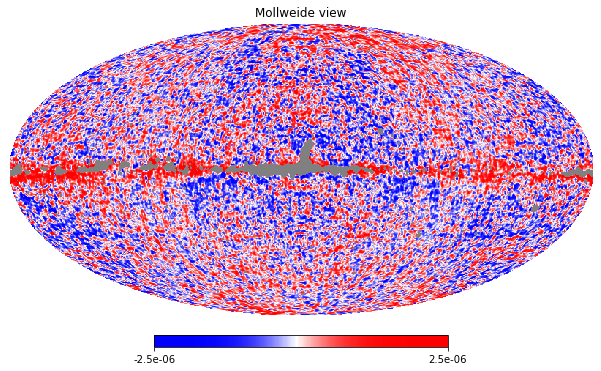

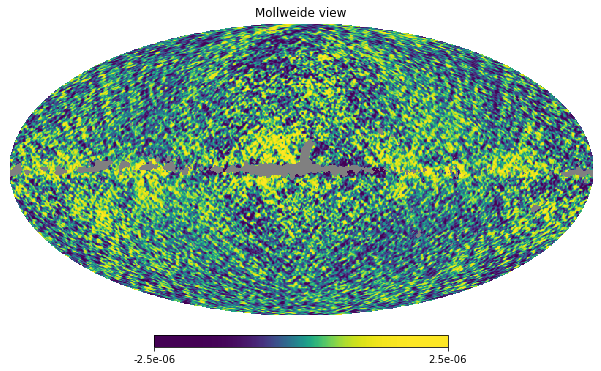

In [23]:
hp.mollview(maq_lpDXS, norm='hist', min=-2.5*1e-6, max=2.5*1e-6, cmap='bwr')
hp.mollview(mau_lpDXS, norm='hist', min=-2.5*1e-6, max=2.5*1e-6)